## Directories Required
Ensure you have the following directory structure no matter where you are hosting the data: GCP Storage, GCP Compute Engine local disk, Google Drive or your local desktop/laptop.

The root folder on your local drive should be 'image_caption'. The rest follow from it.<br/>

For Colab, there is one additional requirement. Ensure 'image_caption' is placed under 'Colab Notebooks' folder (which is created by Google automatically the first time you create a Colab notebook). Why? Since files within Google Colab are referenced with their full path starting all the way back to "drive".<br/>
For example:<br/>
filename = 'drive/My Drive/Colab Notebooks/Image Caption/Data/Flickr_8K/Labels/Flickr_8K.token.txt'<br/>
filename = 'drive/My Drive/Colab Notebooks/Image Caption/Data/Flickr_30K/Labels/results.txt'<br/>


<div>
    <img src="https://drive.google.com/uc?id=1DrVeLA0fz0XYrPq0CZs6eAvRZbsB4GE1" alt="Broken URL. Contact Anand Menon." width="60%"/>
</div>

## Files Required
The following files are required to run the code. All the files are shared, so you should ideally be able to copy the entire directory structure. Warning: It is over 2 GB, soon to be 10 GB.<br/>
You will need to recreate the folder structure locally (with files and all) since the code writes files back to it.

[Link to Data folder](https://drive.google.com/open?id=1bQtuMVTyaXCMGMC0XifOC2aKb1UGTSo6)

### Dataset Files: Train, test, validate
* Flickr_8K
  * Data/Flickr_8K/Images/&lt;Images&gt;<br/>
  * Data/Flickr_8K/Labels/&lt;Labels&gt;<br/>
* Flickr_30K
   * Data/Flickr_30K/Images/&lt;Images&gt;<br/>
   * Data/Flickr_30K/Labels/&lt;Labels&gt;<br/>

### Word Vectors File

* Data/Vectors/&lt;Word vector file&gt;<br/>
You only need one of these depending upon how well trained the vectors need to be for your need. The 300D is better (and much bigger) than the 100D file. Alternatively, feel free to use your own.
    * glove.6B.100d.txt
    * glove.6B.300d.txt

### Transfer Learning Net: Features File
In order to speed up training & testing, all features from our underlying transfer learning net are generated in-advance of the train/test code blocks. The first time you run this code, generate the features once by setting GEN_FEATURES = True above. Then set it back to False. The generated file is large, and it will take ~30 minutes to create.

## Change Log
1. 13 Apr: Switched to using GloVe encoding from a custom Embedding layer. The latter has the downside that if the number of training inputs are insufficient, the word embeddings it creates will be bad...and there is no easy way to tell if the number of training inputs are insufficient for this particular part of the net (the learning curves will give a global answer). Using GloVe word vectors eliminates this problem. In addition, it means the net is not having to learn the 'meaning' of words at the same time as it is learning to generate captions; hence less distractions for its nano-brain.
2. 20 Apr: Dropped words that occur less frequently than 0.005% of the time in the corpus consisting of all captions. This tiny filter dramatically dropped the vocabulary from ~7500 words down to ~1100 words. Naturally, performance went up a bit with very little impact to the English of it all.
3. 24 Apr: Switched the underlying pre-trained net over from VGG16 over to Inception v3. VGG16 is a big, plodding net and its architecture older than Inception. Inception also outperformed VGG16 in ImageNet, so overall it helped the performance a bit.
4. 30 Apr: Cleaned up the code a bit and switched over to ResNet. The experiment here was to try and mimic human behaviour a bit more. Humans are great at fill in the blanks: The car is turning &lt;blank&gt;. So what is needed here is an identity function that helps recall prior learned patterns effectively.

In [40]:
#Clear all vars
%reset -f

#Common imports
import numpy as np
from numpy import array
import pickle
import time

#Init code
def initialize():
    """
    """
    import sys

    # Init
    dictInit = {}
    dictInit['GEN_FEATURES'] = False  #Set to True if features need to be generated through the underlying pre-trained net
    dictInit['TRAIN_MODEL'] = True  #Set to True if our custom net needs to learn the dataset
    dictInit['TL_MODEL'] = 'Inceptionv3'  #Pre-trained model used for recognizing obects within images. One of Inceptionv3 or VGG16 trained on ImageNet.
    dictInit['MAX_SAMPLES'] = 5000  #Maximum number of samples to train & test with. Set to -1 for training on full train set.
    dictInit['DATASET'] = 'Flickr_8K'  #One of 'Flickr_8K', 'Flickr_30K'

    #Change directory access paths depending upon where you are running
    dictInit['IN_COLAB'] = 'google.colab' in sys.modules
    if dictInit['IN_COLAB']:
        from google.colab import drive  #Access google drive to load data
        drive.mount('/content/drive')
        dictInit['DIR_PREFIX'] = 'drive/My Drive/Colab Notebooks/image_caption/Data/'
    else:
        dictInit['DIR_PREFIX'] = './Data/'  #Local

    #All directory & file names; Train, Validate, Test etc.
    dictInit['DIR_ALL_IMAGES'] = dictInit['DIR_PREFIX'] + dictInit['DATASET'] + '/Images/'
    dictInit['FN_ALL_LABELS'] = dictInit['DIR_PREFIX'] + dictInit['DATASET'] + '/Labels/' + dictInit['DATASET'] + '.captions.txt'
    dictInit['FN_GEN_MODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_transfer_learning_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_GEN_RESULT'] = dictInit['DIR_PREFIX'] + 'Model/features_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '.pkl'
    dictInit['FN_TRAIN_MODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_custom_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_WEIGHTS'] = dictInit['DIR_PREFIX'] + 'Weights/weights.best_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '.hdf5'
    dictInit['FN_TRAIN_REMODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_custom_from_weights_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_TEST_RESULTS'] = dictInit['DIR_PREFIX'] + 'Model/results_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '_' + str(dictInit['MAX_SAMPLES']/5)
    dictInit['FN_LEARN_CURVES'] = dictInit['DIR_PREFIX'] + 'Model/results_lc_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '_' + str(dictInit['MAX_SAMPLES']/5)
    dictInit['FN_BLEU'] = dictInit['DIR_PREFIX'] + 'Model/results_lc_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '_' + str(dictInit['MAX_SAMPLES']/5) + '_BLEU.txt'

    #GloVe embeddings
    dictInit['EMBEDDING_DIM'] = 100
    if dictInit['EMBEDDING_DIM'] == 100:
        dictInit['FN_EMBEDDING'] = dictInit['DIR_PREFIX'] + 'Vectors/' + 'glove.6B.100d.txt'
    elif dictInit['EMBEDDING_DIM'] == 300:
        dictInit['FN_EMBEDDING'] = dictInit['DIR_PREFIX'] + 'Vectors/' + 'glove.6B.300d.txt'
    
    #Retain or drop colours in dataset
    dictInit['REMOVE_COLOURS'] = True
    
    #Return
    return dictInit

#Initialize key variables
dictInit = initialize()
for key, val in dictInit.items():
    print(key, '\t', val)
if (dictInit['MAX_SAMPLES'] == -1) or (dictInit['MAX_SAMPLES'] > 2000):
    DEBUG = False
else:
    DEBUG = True
print('DEBUG', '\t\t', DEBUG)

GEN_FEATURES 	 False
TRAIN_MODEL 	 True
TL_MODEL 	 Inceptionv3
MAX_SAMPLES 	 5000
DATASET 	 Flickr_8K
IN_COLAB 	 False
DIR_PREFIX 	 ./Data/
DIR_ALL_IMAGES 	 ./Data/Flickr_8K/Images/
FN_ALL_LABELS 	 ./Data/Flickr_8K/Labels/Flickr_8K.captions.txt
FN_GEN_MODEL 	 ./Data/Model/model_transfer_learning_Inceptionv3.png
FN_GEN_RESULT 	 ./Data/Model/features_Inceptionv3_Flickr_8K.pkl
FN_TRAIN_MODEL 	 ./Data/Model/model_custom_Inceptionv3.png
FN_WEIGHTS 	 ./Data/Weights/weights.best_Inceptionv3_Flickr_8K.hdf5
FN_TRAIN_REMODEL 	 ./Data/Model/model_custom_from_weights_Inceptionv3.png
FN_TEST_RESULTS 	 ./Data/Model/results_Inceptionv3_Flickr_8K_1000.0
FN_LEARN_CURVES 	 ./Data/Model/results_lc_Inceptionv3_Flickr_8K_1000.0
FN_BLEU 	 ./Data/Model/results_lc_Inceptionv3_Flickr_8K_1000.0_BLEU.txt
EMBEDDING_DIM 	 100
FN_EMBEDDING 	 ./Data/Vectors/glove.6B.100d.txt
REMOVE_COLOURS 	 True
DEBUG 		 False


In [41]:
#Generate features via underlying pre-trained net
if dictInit['GEN_FEATURES']:
    from pickle import dump
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    from keras.models import Model
    from keras.utils import plot_model
    from os import listdir
    
    #Config
    if dictInit['TL_MODEL'] == 'Inceptionv3':
        from keras.applications import InceptionV3
        from keras.applications.inception_v3 import preprocess_input
    else:        
        from keras.applications.vgg16 import VGG16
        from keras.applications.vgg16 import preprocess_input

    #Extract features from each photo in the directory
    def extract_features(directory):
        """
        """
        #Load Model
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            model = InceptionV3(include_top=False, weights='imagenet')
        else:
            model = VGG16(include_top=False, weights='imagenet')

        #Remove the top layer, retaining the features generated up-to the layer below
        #model.layers.pop()
        model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
        #print(model.summary())
        plot_model(model, to_file = dictInit['FN_GEN_MODEL'], show_shapes=True)

        #Extract features from each photo
        TARGET_SIZE = (0,0)
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            TARGET_SIZE = (299, 299)
        else:
            TARGET_SIZE=(224, 224)
        counter = 0
        features = dict()
        start = time.time()
        current = start
        for fn in listdir(directory):
            #Load image
            image = load_img(directory+'/'+fn, target_size=TARGET_SIZE, interpolation='bicubic')

            #Expand dims to include batch size
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

            #Prepare & predict
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[fn] = feature
            if counter % 1000 == 0:
                if counter == 0:
                    print(counter, 0, fn)
                else:
                    print(counter, 1000.0/(time.time()-current), (time.time()-current), time.time(), fn)
                current = time.time()
            counter += 1
        return features

    # Extract features from all images
    features = extract_features(dictInit['DIR_ALL_IMAGES'])
    print('# of Extracted Features: %d' % len(features), (current-start)/60.0)

    # Save to file
    dump(features, open(dictInit['FN_GEN_RESULT'], 'wb'))

In [42]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Stores an instance of a sample
class Xy:
    """
    """
    def __init__(self, photo_id):
        #Init
        self.id = photo_id
        self.features = None
        self.captions = []
        self.captions_bookends = []
        self.prediction = None
    
    def add_caption(self, cap):
        self.captions.append(cap)
    
    def add_bookends(self):
        self.captions_bookends = ['startseq ' + cap + ' endseq' for cap in self.captions]
        return self.captions_bookends
    
    def add_prediction(self, prediction):
        self.prediction = prediction.replace('startseq ','').replace(' endseq','')
    
    #Print
    def toString(self):
        res = self.id + '\n'
        if self.features is not None:
            res += '\t' + str(self.features.shape) + '\n'
        for cap in self.captions:
            res += "\t'" + cap + "'\n"
        if self.prediction is not None:
            res += '\t' + self.prediction + '\n'
        return res

#Stores all samples belonging to a particular data; train, dev test.
class Dataset:
    """
    Attribute name: One of Train, Dev, Test.
    Attribute samples: List of samples.
    """
    def __init__(self, name, samples):
        #Init
        self.name = name
        self.samples = samples
        
        #Create dict for easy access
        self.dictSamples = {}
        for xy in self.samples:
            self.dictSamples[xy.id] = xy
    
    #Add features samples
    def add_features(self, dict_features_all):
        dict_features = {id: dict_features_all[id] for id in self.dictSamples}
        for id, features in dict_features.items():
            self.dictSamples[id].features = features[0]  #Else shape = (1,N)

    #Create inputs images, input sequences and output words for an image
    def create_inputs(self, ca):
        """
        Create inputs images, input sequences and output words for an image.
        """
        #Foreach sample...
        X1, X2, y = list(), list(), list()
        for xy in self.samples:
            #Foreach bookended caption, encode text to integers
            sequences = ca.tokenizer.texts_to_sequences(xy.add_bookends())

            #Foreach sequence, form inputs incrementing 1 word at a time
            for seq in sequences:
                #Split sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    #Split & pad input, encode output as one-hot
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = ca.max_seq_len)[0]
                    out_seq = to_categorical([out_seq], num_classes = ca.vocab_size)[0]

                    #Store
                    X1.append(xy.features)
                    X2.append(in_seq)
                    y.append(out_seq)

        #Convert to numpy arrays
        self.X1 = np.array(X1)
        self.X2 = np.array(X2)
        self.y = np.array(y)
        
    #Print
    def toString(self):
        res = self.name + '\n'
        for xy in self.samples:
            res += '\t' + xy.toString() + '\n'
        return res

In [43]:
#Helper method for loading provided filename
def read_file(filename, max_lines=-1):
    """
    """
    with open(filename) as f:
        if max_lines > 0:
            doc = [next(f).replace('\n','') for x in range(max_lines)]  #Read only the # of lines specified
        else:
            doc = f.read().splitlines()  #Read all lines
        return doc

#Load captions from input file
def load_captions():
    """
    """
    #Read file
    doc = read_file(dictInit['FN_ALL_LABELS'], dictInit['MAX_SAMPLES'])
    print(type(doc), len(doc))
    if DEBUG:
        print(doc[0:10])

    #--Extract name and captions associated with each image and save in Xy--
    #If dataset Flickr_8K...
    lines = []
    if dictInit['DATASET'] == 'Flickr_8K':
        #Split on tabs
        for line in doc:
            if line.strip() == '':
                continue
            tokens = line.split('\t')
            #Skip '_577c3a7d70....#1' part of name  #1001773457_577c3a7d70.jpg#1	Two dogs are playing with each other .
            photo_id = tokens[0].split('_')[0]+'.'+tokens[0].split('.')[1][0:-2]
            photo_caption = tokens[1]  #Rest of words
            lines.append((photo_id, photo_caption))
    elif dictInit['DATASET'] == 'Flickr_30K':
        #Split on pipes
        first = True  #Skip header "image_name| comment_number| comment"
        for line in doc:
            if (first) or (line.strip() == ""):
                first = False
                continue
            tokens = line.split('|')
            photo_id = tokens[0]
            photo_caption = tokens[2]
            lines.append((photo_id, photo_caption))

    #Concatenate descriptions by image
    dictCaptions = {}  #Key = Photo identifier, Value = Xy containing photo id & list of captions
    for tokens in lines:
        id = tokens[0]
        caption = tokens[1]
        if id not in dictCaptions:
            dictCaptions[id] = Xy(id)
        dictCaptions[id].add_caption(caption)
    return dictCaptions

#Load captions
dictCaptions = load_captions()
print('# of samples:', len(dictCaptions), '\n')
if DEBUG:
    counter = 0
    for key,val in dictCaptions.items():
        print(key, val.toString())
        if counter>1:
            break;
        counter += 1

<class 'list'> 5000
# of samples: 1000 



In [44]:
import re
import nltk
# nltk.download('averaged_perceptron_tagger')
import time


def priorTag(i, pos):
    if i > 0:
        return pos[i-1]
    else:
        return None

def nextTag(i, length, pos):
    if i <= length-2:
        return pos[i+1]
    else:
        return None

def isLastTag(i, length):
    if i == length-1:
        return True
    else:
        return False

def isAdjective(tag):
    if tag is None:
        return False
    if (tag[1]=='JJ') or (tag[1]=='ADJ'):
        return True
    else:
        return False

def isConjunction(tag):
    if tag is None:
        return False
    if (tag[1]=='CC') or (tag[1]=='CONJ'):
        return True
    else:
        return False

def isGerund(tag):
    if tag is None:
        return False
    if (tag[1]=='VBG'):
        return True
    else:
        return False

def isPreposition(tag):
    if tag is None:
        return False
    if (tag[1]=='IN'):
        return True
    else:
        return False

def isNoun(tag):
    if tag is None:
        return False
    if (tag[1]=='NOUN'):
        return True
    else:
        return False

def isVerb(tag):
    if tag is None:
        return False
    if tag[1].startswith('VB'):
        return True
    else:
        return False

def getPosPattern(pos):
    return [tag[1] for tag in pos]


#Cleanup text
def cleanup_text(dictCaptions):
    """
    Remove punctuation & special characters, lowercase captions, remove hanging 's, remove extra spaces.
    Returns the sum of # of words across all captions. Includes duplicate counts.
    """
    
    #Attributes to be replaced
    dictReplacements = {'little girls':'children', 'little girl':'child', 'little boys':'children', 'little boy':'child', 
                        'young girls':'children', 'young girl':'child', 'young boys':'children', 'young boy':'child', 
                        'gentleman':'person', 'lady':'person', 'youths':'people', 'guys ':'people ', 'guy ':'person ',
                        ' boys':' children', 'girls':'children', ' boy ':' child ', ' girl ':' child ', 'kids':'children',
                        'females':'people', 'males':'people', 'female':'person', ' male ':' person ', ' man ':' person ', 'woman':'person', ' men ':' people ', 'women':'people',
                        ' 1 ':' one ', ' 2 ':' two ', ' 3 ':' three ', ' 4 ':' four ', ' 5 ':' five ', ' 6 ':' six ', ' 7 ':' seven ',
                        'baseball cap':'cap', 'ball cap':'cap', 'backwards ':'', 'top hat':'hat', ' tshirt':' shirt', 
                        'officer':'person', 'policeman':'person', 'police man':'person', '':'', '':'', '':'', 
                        'babies':'children', 'infants':'children', 'infant':'child', 'person children':'children', 'toddlers':'children', 
                        'toddler':'child', 'child child':'child', 'baby child':'child', 'baby':'child', '':'', '':'', '':'',
                       }

    dictRegexReplacements = {'^(man)':'person', '^(boy) ':' child ', '^(girl) ':' child ',
                             '^1 ':'one ', '^2 ':'two ', '^3 ':'three', '^4 ':'four ', '^5 ':'five ', '^6 ':'six ', '^7 ':'seven ',
    #                          '':'', '':'', '':'', '':'', '':'', '':'', '':'', '':'', '':''
                            }

    posTemplate = [['CD', 'VBZ', 'IN', 'JJ', 'DT', 'JJ', 'VBZ', 'IN', 'JJ'], ['CD', 'VBZ', 'IN', 'JJ', 'DT', 'JJ', 'IN', 'JJ'], 
                   ['CD', 'IN', 'DT', 'JJ', 'NN', 'CD', 'IN', 'DT', 'JJ', 'NN'], ['CD', 'IN', 'DT', 'JJ', 'NN'], 
                   ['JJ', 'TO', 'DT', 'JJ'], ['NN', 'CC', 'JJ']]

    #Patterns
    p1 = re.compile(r'( a [aeiou])+')  #Match a apple
    p2 = re.compile(r'( an [b-df-hj-np-tv-z])+')  #Match an ruler

    #Pre-process
    for id, xy in dictCaptions.items():
        clean = []
        for caption in xy.captions:
            #Punctuation
            cap = caption.lower().replace(" 's", "s").strip()
            cap = re.sub('[^A-Za-z0-9 ]+', '', cap)  #Remove special chars
            cap = re.sub('( )+', ' ', cap)

            #Replace equivalence classes
            for key,value in dictReplacements.items():
                cap = cap.replace(key, value)
            for key, value in dictRegexReplacements.items():
                cap = re.sub(key, value, cap)
            cap = cap.strip()

            #Init pos
            pos = nltk.pos_tag(cap.split(' '))
            length = len(pos)
            tokens = []
            mask = [1]*(length+2)

            #Replace entire strings that match posTemplate
            posPattern = getPosPattern(pos)
            pps = ' '.join(posPattern)
            for pt in posTemplate:
                pts = ' '.join(pt)
                if pts in pps:
                    start = -1
                    i, j = 0, 0
                    while i<len(posPattern) and j<len(pt):
                        if posPattern[i] == pt[j]:
                            if start == -1:
                                start = i
                            j += 1
                        else:
                            j = 0
                            start = -1
                            #Check from the start again of template pattern
                            if posPattern[i] == pt[j]:
                                if start == -1:
                                    start = i
                                j += 1
                        i += 1
                    for j in range(start, start+len(pt)):
                        mask[j] = 0
                    break;  #No need to search for further patterns within same string

            for i in range(len(pos)):
                tag = pos[i]
                if mask[i] == 1:
                    #If next tag is a determinant, replace all 3 tags 'black & brown'
                    if isAdjective(tag) and tag[0]!='other' and not isLastTag(i, length):
                        pTag = priorTag(i, pos)
                        nTag = nextTag(i, length, pos)
                        if isConjunction(nTag):
                            mask[i] = 0
                            mask[i+1] = 0
                            mask[i+2] = 0
                        elif isGerund(nTag):
                            mask[i] = 0
                            mask[i+1] = 0
                        elif isVerb(pTag):
                            mask[i] = 1
                        else:
                            mask[i] = 0
                        if isPreposition(pTag) and isVerb(nTag):  #If the preceeding tag is a preposition & the next a verb, delete preposition
                            mask[i-1] = 0

            #Only keep words with mask = 1
            cap = []
            for i in range(len(pos)):
                if mask[i] == 1:
                    cap.append(pos[i][0])
            cap = ' '.join(cap)

            #Fix grammar for a vs. an followed by vowels / consonants
            cap = ' ' + cap
            match = p1.match(cap)
            matches = re.finditer(p1, cap)
            for match in matches:
                cap = cap[0:match.start(1)] + ' |' + cap[match.start(1)+2:match.end(1)] + cap[match.end(1):len(cap)]
            cap = cap.replace('|', 'an')
            matches = re.finditer(p2, cap)
            for match in matches:
                cap = cap[0:match.start(1)+1] + ' |' + cap[match.start(1)+3:match.end(1)] + cap[match.end(1):len(cap)]
            cap = cap.replace(' |', 'a')
            
            #Save
            clean.append(cap)
        xy.captions = clean

#Cleanup text
start = time.time()
cleanup_text(dictCaptions)
print('Time taken:', round(time.time()-start,2))
if DEBUG:
    counter = 0
    for key,val in dictCaptions.items():
        print(key, val.toString())
        if counter>1:
            break;
        counter += 1

Time taken: 3.01


In [45]:
import random

#Count frequency of all words
def count_word_freq(dictCaptions):
    """
    """
    #Aggregate words across all captions
    allWordsInCaptions = []
    for id, xy in dictCaptions.items():
        for caption in xy.captions:
            allWordsInCaptions.extend(caption.split(' '))
    numWords = len(allWordsInCaptions)

    #Count
    dictWords = {}
    for word in allWordsInCaptions:
        if word not in dictWords:
            dictWords[word] = 0
        dictWords[word] += 1
    return numWords, dictWords

#Count frequency of all words
numWords, dictWords = count_word_freq(dictCaptions)
print('# of total words across all captions:', numWords)
print('# of unique words:', len(dictWords), '\n')
if DEBUG:
    for key in random.sample(list(dictWords.keys()), 5):
        print(key+':', dictWords[key])

# of total words across all captions: 54656
# of unique words: 2949 



In [46]:
#Drop infrequent words from captions, reducing vocabulary size
def drop_infrequent(dictCaptions, dictWords):
    """
    """
    #Form dict of frequent words
    truncated = []
    for word in dictWords.keys():
        if dictWords[word]/numWords > 0.00004:  #0.005%
            truncated.append(word)
    dictWordsTrunc = dict.fromkeys(truncated, 0)

    #Drop infrequent
    for id, xy in dictCaptions.items():
        newCaptions = []
        for caption in xy.captions:
            newCaptions.append(' '.join([word for word in caption.split(' ') if word in dictWordsTrunc]))
        xy.captions = newCaptions

#Drop infrequent words
drop_infrequent(dictCaptions, dictWords)
print('Total samples:', len(dictCaptions))
print('# of total words across all captions:', sum([len(cap.split(' ')) for xy in dictCaptions.values() for cap in xy.captions]))
print('# of unique words:', len(set([words for sublist in [cap.split(' ') for xy in dictCaptions.values() for cap in xy.captions] for words in sublist])), '\n')
if DEBUG:
    for key in random.sample(list(dictCaptions.keys()), 2):
        print(key, dictCaptions[key].toString())

Total samples: 1000
# of total words across all captions: 52472
# of unique words: 1206 



Top 3 sequence lengths: [30, 27, 26]


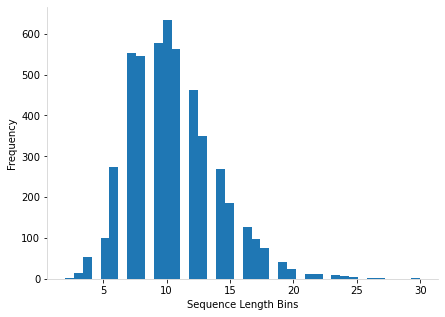

Skew: 0.815
99th Percentile: 24


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

#4 May: Limit caption length to N'th percentile
seq_lengths = [len(cap.split(' ')) for xy in dictCaptions.values() for cap in xy.captions]
seq_lengths.sort(reverse=True)
print('Top 3 sequence lengths:', seq_lengths[0:3])

#Histogram
plt.rcParams['figure.facecolor'] = 'white'
fig=plt.figure(figsize=(7, 5))
numBins = 40
plt.hist(seq_lengths, bins=numBins)
ax = plt.gca()
ax.set_xlabel('Sequence Length Bins', color='black')
ax.set_ylabel('Frequency', color='black')
ax.spines['bottom'].set_color('lightgrey')
ax.spines['left'].set_color('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
print('Skew:', round(skew(seq_lengths),3))

#Get the N'th percentile
p99 = int(np.percentile(seq_lengths, 99.8))  #N'th percentile
print('99th Percentile:', p99)

#Trunc captions to p99
for id, xy in dictCaptions.items():
    newCaptions = []
    for caption in xy.captions:
        newCaptions.append(' '.join(caption.split(' ')[0:p99]))
    xy.captions = newCaptions

#Print
counter = 0
if DEBUG:
    for id, xy in dictCaptions.items():
        print(id)
        for caption in xy.captions:
            print('\t', caption)
        if counter>1:
            break;
        counter += 1
    
    #Print longest description
    print('\nLongest description belongs to...')
    temp = -1
    lid = -1
    for id, xy in dictCaptions.items():
            for caption in xy.captions:
                if len(caption.split(' ')) > temp:
                    temp = len(caption.split(' '))
                    lid = id
    print(lid, temp)
    print(dictCaptions[lid].toString())

In [48]:
from sklearn.model_selection import train_test_split

#Create train, dev & test datasets
def split_dataset(dictCaptions):
    #Split
    X = list(dictCaptions.keys())
    y = list(dictCaptions.values())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)  #Train+Dev vs. Test
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.20, random_state=42)  #Train vs. Dev
    
    #Save
    dsTrain = Dataset('Train', y_train)
    dsDev = Dataset('Dev', y_dev)
    dsTest = Dataset('Test', y_test)
    return dsTrain, dsDev, dsTest

#Split
dsTrain, dsDev, dsTest = split_dataset(dictCaptions)
print(len(dsTrain.samples)+len(dsDev.samples)+len(dsTest.samples), ':', len(dsTrain.samples), len(dsDev.samples), len(dsTest.samples))

1000 : 640 160 200


In [49]:
from keras.preprocessing.text import Tokenizer

class CorpusAttributes:
    """
    Attribute tokenizer: Keras tokenizer for converting words to integers.
    Attribute max_seq_len: Maximum sequence length amongst all captions; includes bookends.
    Attribute vocab_size: Number of words in vocabulary + 1.
    """
    def __init__(self, tokenizer, max_seq_len, vocab_size):
        #Init
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size

#Convert the dataset into the right format for our custom net + LSTM
def process_dataset(dsTrain, dsDev, dsTest):
    #Create tokenizer and fit on train set
    only_captions = [captions for xy in dsTrain.samples for captions in xy.add_bookends()]
    max_seq_len = max([len(cap.split(' ')) for cap in only_captions])
    
    #Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(only_captions)
    vocab_size = len(tokenizer.word_index) + 1
    ca = CorpusAttributes(tokenizer, max_seq_len, vocab_size)
    
    #Load & save transfer learning features from pickle file
    dict_features_all = pickle.load(open(dictInit['FN_GEN_RESULT'], 'rb'))
    dsTrain.add_features(dict_features_all)
    dsDev.add_features(dict_features_all)
    dsTest.add_features(dict_features_all)
    
    #Create inputs for upcoming NN.fit() method
    dsTrain.create_inputs(ca)
    dsDev.create_inputs(ca)
    dsTest.create_inputs(ca)
    
    #Return
    return ca

#Process dataset
ca = process_dataset(dsTrain, dsDev, dsTest)
print('Longest sequence length:', ca.max_seq_len)
print('Vocabulary size:', ca.vocab_size, '\n')
print(len(dsTrain.samples), '\t', len(dsDev.samples), '\t', len(dsTest.samples))
print(dsTrain.X1.shape, '\t', dsTrain.X2.shape, '\t', dsTrain.y.shape)
print(dsDev.X1.shape, '\t', dsDev.X2.shape, '\t', dsDev.y.shape)
print(dsTest.X1.shape, '\t', dsTest.X2.shape, '\t', dsTest.y.shape)

Longest sequence length: 26
Vocabulary size: 1128 

640 	 160 	 200
(33319, 2048) 	 (33319, 26) 	 (33319, 1128)
(8534, 2048) 	 (8534, 26) 	 (8534, 1128)
(10294, 2048) 	 (10294, 26) 	 (10294, 1128)


In [50]:
if DEBUG:
    counter = 0
    for val in dsTrain.X1:
        print(val.shape, val)
        counter += 1
        if counter > 3:
            break;
    print(dsTrain.samples[0].toString())

## Create & Run Model

In [51]:
#Create a matrix of GloVe word vectors of all words in our vocabulary
def createEmbeddingMatrix(ca):
    #Load GloVe word vectors
    start = time.time()
    dict_glove = {}
    lines = read_file(dictInit['FN_EMBEDDING'])
    with open(dictInit['FN_EMBEDDING']) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            dict_glove[word] = coefs
    print('# of vectors loaded:', len(dict_glove))
    print('Time taken:', round(time.time()-start,1))

    #Create embedding matrix
    embedding_matrix = np.zeros((ca.vocab_size, dictInit['EMBEDDING_DIM']))
    for word, i in ca.tokenizer.word_index.items():
        embedding_vector = dict_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  #Words not found in GloVe will be all-zeros
    return embedding_matrix

#Create a matrix of GloVe word vectors of all words in our vocabulary
if dictInit['TRAIN_MODEL']:
    print('Loading vectors...')
    embedding_matrix = createEmbeddingMatrix(ca)
    print(embedding_matrix.shape)

Loading vectors...
# of vectors loaded: 400000
Time taken: 17.9
(1128, 100)


In [ ]:
if dictInit['TRAIN_MODEL']:
    from keras.applications import densenet
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Embedding
    from keras.layers import Dropout
    from keras.layers.merge import add
    from keras.callbacks import ModelCheckpoint
    from keras.utils import plot_model
    
    #Define the captioning model
    def define_model(ca):
        """
        """
        #Transfer learning model
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            branch1_in = Input(shape=(2048,))
        else:
            branch1_in = Input(shape=(4096,))
        branch1_drop = Dropout(0.5)(branch1_in)
        branch1_dense = Dense(65, activation='relu')(branch1_drop)
        
        #LSTM model
        branch2_in = Input(shape=(ca.max_seq_len,))
        # branch2_embed = Embedding(ca.vocab_size, 300, mask_zero=True)(branch2_in)
        branch2_embed = Embedding(ca.vocab_size, dictInit['EMBEDDING_DIM'], weights=[embedding_matrix], input_length=ca.max_seq_len, trainable=False)(branch2_in)
        branch2_lstm = LSTM(65)(branch2_embed)
        
        #Hidden layer
        hidden_add = add([branch1_dense, branch2_lstm])
        hidden_dense = Dense(65, activation='relu')(hidden_add)
        hidden_out = Dense(ca.vocab_size, activation='softmax')(hidden_dense)
        
        #Model: [image, seq] --> [word]
        model = Model(inputs=[branch1_in, branch2_in], outputs=hidden_out)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
        print(model.summary())
        plot_model(model, to_file=dictInit['FN_TRAIN_MODEL'], show_shapes=True)
        return model

    #Define model
    start = time.time()
    print('Start time:', start)
    model = define_model(ca)
    checkpoint = ModelCheckpoint(dictInit['FN_WEIGHTS'], monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    #Fit
    history = model.fit([dsTrain.X1, dsTrain.X2], dsTrain.y, epochs=3, 
              verbose=2, callbacks=[checkpoint], validation_data=([dsDev.X1, dsDev.X2], dsDev.y))
    print('\nTotal time taken:', round(time.time()-start,1))

Start time: 1589544026.3525214
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 100)      112800      input_2[0][0]                    
_____________________________________________________________

## Model Evaluation

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt

#Plot learning curves
def plotCurve(history, ax, metric1, metric2, title, title_x, title_y):
    ax.plot(history.history[metric1], '-*', label=metric1)
    ax.plot(history.history[metric2], '--*', label=metric2)
    ax.set_title('Training & Validation Loss', color='black')
    ax.legend(loc='best', shadow=True)
    ax.set_xlabel(title_x, color='black')
    ax.set_ylabel(title_y, color='black')
    ax.spines['bottom'].set_color('lightgrey')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

#Plot learning curves
if dictInit['TRAIN_MODEL']:
    #Init plot
    plt.rcParams['figure.facecolor'] = 'white'
    fig=plt.figure(figsize=(22, 24))
    
    #Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plotCurve(history, ax1, 'loss', 'val_loss', 'Training & Valiation Loss', '# of Epochs', 'Loss')
    plotCurve(history, ax2, 'accuracy', 'val_accuracy', 'Training & Valiation Accuracy', '# of Epochs', 'Accuracy')
    plt.savefig(dictInit['FN_LEARN_CURVES'] + '_' + datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + '.png',
                                                                            bbox_inches='tight', facecolor='white')
    plt.show()

In [ ]:
from numpy import argmax
from keras.models import load_model
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

# generate a description for an image
def generate_desc(dictLookup, model, ca, photo_features):
    """
    """
    
    #Iteratively predict one word at a time
    in_text = 'startseq'
    for i in range(ca.max_seq_len):
        #Encode & Pad
        sequence = ca.tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen = ca.max_seq_len)
        
        #Predict next word
        yhat = model.predict([photo_features,sequence], verbose=0)
        yhat = argmax(yhat)  #Index of highest probability
        word = dictLookup.get(yhat)
        
        #Stop if we cannot find a word within our vocabulary or predict the end
        if (word is None) or (word == 'endseq'):
            break
        
        #Append to input
        in_text += ' ' + word
        
    #Return
    return in_text

#Evaluate model
def evaluate_model(model, ca, dsTest):
    """
    """
    
    #Create a reverse lookup to go from integer encodings back to english words
    dictLookup = dict([(value,key) for (key,value) in ca.tokenizer.word_index.items()])
    
    #Predict caption foreach test case...
    for xy in dsTest.samples:
        yhat = generate_desc(dictLookup, model, ca, np.expand_dims(xy.features, axis=0))  #Add batch size to features
        xy.add_prediction(yhat)
    
    #Format input for BLEU, Compute sentence level BLEU score
    dictBleu = {}
    candidate, references = list(), list()
    for xy in dsTest.samples:
        references.append([cap.split(' ') for cap in xy.captions])
        candidate.append(xy.prediction.split(' '))
        sbleu1 = str(round(sentence_bleu([cap.split(' ') for cap in xy.captions], xy.prediction.split(' '), weights=(1.0, 0, 0, 0)),4))
        sbleu2 = str(round(sentence_bleu([cap.split(' ') for cap in xy.captions], xy.prediction.split(' '), weights=(0.5, 0.5, 0, 0)),4))
        sbleu3 = str(round(sentence_bleu([cap.split(' ') for cap in xy.captions], xy.prediction.split(' '), weights=(0.3, 0.3, 0.3, 0)),4))
        sbleu4 = str(round(sentence_bleu([cap.split(' ') for cap in xy.captions], xy.prediction.split(' '), weights=(0.25, 0.25, 0.25, 0.25)),4))
        dictBleu[xy.id] = (xy, [sbleu1, sbleu2, sbleu3, sbleu4])
    
    #Compute BLEU score
    print('BLEU-1: %f' % corpus_bleu(references, candidate, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(references, candidate, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(references, candidate, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25)))
    
    #Return
    return dictBleu

#Load custom from weights if training was not carried out
print('Evaluating model...')
if not dictInit['TRAIN_MODEL']:
    model = load_model(dictInit['FN_WEIGHTS'])
#     plot_model(model, to_file = dictInit['FN_TRAIN_REMODEL'], show_shapes=True)

#Evaluate BLEU score
start = time.time()
dictBleu = evaluate_model(model, ca, dsTest)
print('\nTime taken:', round(time.time()-start,1))

# for key, (xy, sbleu) in dictBleu.items():
#     print(key)
#     print(sbleu, '\t', xy.prediction)
#     for cap in xy.captions:
#         print('\t', cap)
#     print('')

In [ ]:
#Save sentence BLEU scores
with open(dictInit['FN_BLEU'], 'w') as fn_bleu:
    for key, (xy, sbleus) in dictBleu.items():
        fn_bleu.write(xy.id + '\t' + xy.prediction + '\n')
        for sb in sbleus:
            fn_bleu.write(sb + '\t')
        fn_bleu.write('\n')
        for cap in xy.captions:
            fn_bleu.write('\t' + cap + '\n')
        fn_bleu.write('\n')

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from textwrap import wrap

#Plot sample test images
def plotSamples(dsTest):
    #Get random images
    testIDs = random.sample(dsTest.dictSamples.keys(), 16)
    print(testIDs)
    
    #Init plot
    plt.rcParams['figure.facecolor'] = 'black'
    fig=plt.figure(figsize=(22, 24))
    fig.patch.set_facecolor('black')
    columns = 4
    rows = 4
    
    #Plot
    for i in range(1, columns*rows+1):
        #Prediction
        yhat = dsTest.dictSamples[testIDs[i-1]].prediction
        
        #Plot image and description together
        img = mpimg.imread(dictInit['DIR_ALL_IMAGES']+testIDs[i-1])
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title("\n".join(wrap(yhat, 50)), color='white')
        ax.set_facecolor('xkcd:black')
        plt.imshow(img)
    plt.savefig(dictInit['FN_TEST_RESULTS']+'_'+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+'.png',
                bbox_inches='tight', facecolor='black', dpi = 50)
    plt.show()

#Plot sample test images
plotSamples(dsTest)

## References

Papineni K, Roukos S, Ward T, Zhu W, (Jul 2002), [BLEU: a method for automatic evaluation of machine translation, Proceedings of the 40th Annual Meeting on Association for Computational Linguistics](https://dl.acm.org/doi/10.3115/1073083.1073135)

Szegedy C et al., (Sep 2014), [Going Deeper with Convolutions,  arXiv:1409.4842 cs.CV](https://arxiv.org/abs/1409.4842)

Simonyan K, Zisserman A, (Sep 2014), [Very Deep Convolutional Networks for Large-Scale Image Recognition, arXiv:1409.1556 cs.CV](https://arxiv.org/abs/1409.1556)

Tanti M, Gatt A, Camilleri K.P., (Aug 2017), [What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?, arXiv:1708.02043 cs.CL](https://arxiv.org/abs/1708.02043)

Brownlee J., (Jun 2019), [How to Develop a Deep Learning Photo Caption Generator from Scratch, Machine Learning Mastery](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

Plummer B. et al., (May 2015), [Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models, arXiv:1505.04870 cs.CV](https://arxiv.org/abs/1505.04870)